In [1]:
import os
import librosa
import re
import numpy as np


In [2]:
def apply_windowing(audio, window_size, hop_size, window_type="hann"):
    """
    Apply windowing to an audio signal.

    Parameters:
    - audio: 1D numpy array, the input audio signal
    - window_size: int, the size of each window in samples
    - hop_size: int, the number of samples to skip between windows (overlap = window_size - hop_size)
    - window_type: str, type of window function ("hann", "hamming", "rectangular", etc.)

    Returns:
    - windows: 2D numpy array where each row is a windowed segment
    """
    # Number of frames
    num_windows = (len(audio) - window_size) // hop_size + 1

    # Select the desired window function
    if window_type == "hann":
        window = np.hanning(window_size)
    elif window_type == "hamming":
        window = np.hamming(window_size)
    elif window_type == "rectangular":
        window = np.ones(window_size)
    else:
        raise ValueError("Unsupported window type. Choose 'hann', 'hamming', or 'rectangular'.")

    # Create windows
    windows = np.array([
        audio[i * hop_size : i * hop_size + window_size] * window
        for i in range(num_windows)
    ])

    return windows

In [3]:
audio_folder="./HW1_M"
files = os.listdir(audio_folder)

audio_files = [file for file in files if file.endswith(('.mp3', '.wav', '.flac', '.ogg'))]

print("Audio files:", len(audio_files))



Audio files: 822


In [4]:
audio_data = []

for audio_file in audio_files[:100]:
    file_path = os.path.join(audio_folder, audio_file)
    # print(f"Loading {audio_file}...")

    y, sr = librosa.load(file_path, sr=48000)
    audio_data.append((audio_file, y, sr))

print("Loaded all audio files!")

Loaded all audio files!


In [5]:
len(audio_data)

100

In [6]:
print(audio_data[0])

('HW1-intro-810103226-male.mp3', array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        2.6920270e-06, -2.8608065e-06, -1.3883619e-07], dtype=float32), 48000)


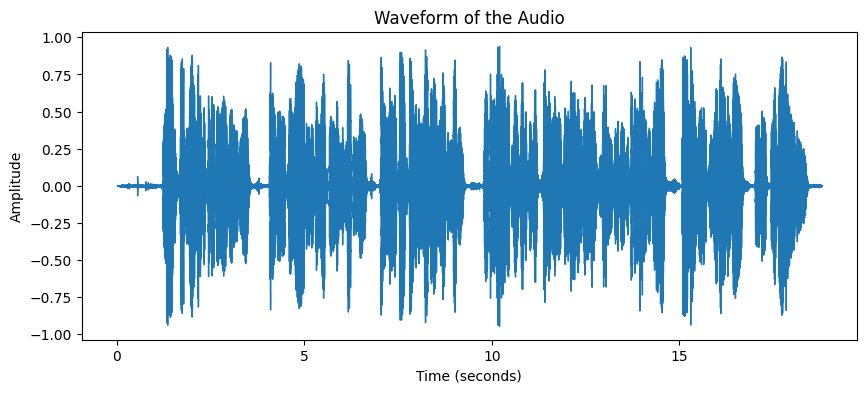

In [7]:
import librosa.display
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
librosa.display.waveshow(audio_data[0][1], sr=sr)
plt.title('Waveform of the Audio')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.show()


In [8]:
label_pattern = re.compile(r".+([0-9]{9}).(male|female|MALE|FEMALE|Male|Female).+")

In [9]:
genders = []
student_ids = []
valid_audios = []

for audio in audio_data:
  matches = list(label_pattern.finditer(audio[0]))
  if matches:
    match = matches[0]
    genders.append(match.group(2).lower())
    student_ids.append(match.group(1))
    valid_audios.append(audio[1])

In [10]:
print(genders)
print(student_ids)

['male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'female', 'male', 'male', 'male', 'female', 'male', 'male', 'male', 'female', 'male', 'female', 'female', 'male', 'female', 'male', 'female', 'male', 'male', 'female', 'male', 'male', 'male', 'male', 'female', 'male', 'female', 'male', 'male', 'female', 'male', 'male', 'female', 'male', 'male', 'male', 'male', 'male', 'female', 'male', 'male', 'male', 'female', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'female', 'male', 'male', 'male', 'male', 'female', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male']
['810103226', '810801075', '810101423', '810103226', '810103226', '810103226', '810801075', '810103226', '810103226', '810103226', '810801075', '810103226', '810801075

In [11]:
def preprocessing(audio):
    y = extract_middle_audio_with_padding(y,1000000)
    

In [12]:
def extract_middle_audio_with_padding(audio, target_length):
    """
    Extract the middle portion of a 1D audio signal and pad if necessary.
    Args:
        audio (np.ndarray): 1D array representing the audio signal.
        target_length (int): Desired length of the extracted middle portion.
    Returns:
        np.ndarray: Middle portion of the audio signal (padded if necessary).
    """
    audio_length = len(audio)

    if audio_length < target_length:
        # Calculate padding on both sides
        pad_width = (target_length - audio_length) // 2
        remainder = (target_length - audio_length) % 2

        # Pad symmetrically (add remainder to the end if necessary)
        padded_audio = np.pad(
            audio,
            pad_width=(pad_width, pad_width + remainder),
            mode='constant',
            constant_values=0
        )
        return padded_audio
    else:
        # Extract middle portion
        start_idx = (audio_length - target_length) // 2
        end_idx = start_idx + target_length
        middle_audio = audio[start_idx:end_idx]
        return middle_audio

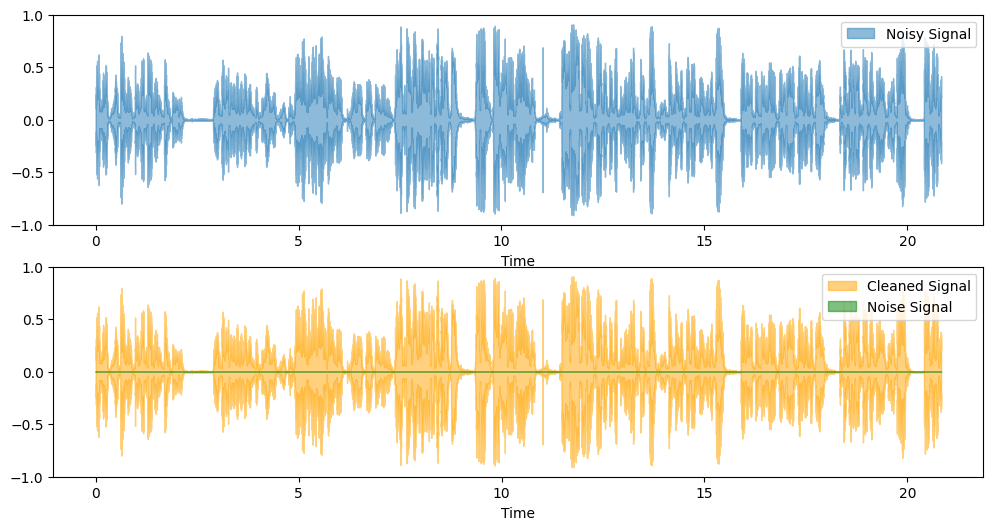

In [13]:

y = valid_audios[8]
y = extract_middle_audio_with_padding(y,1000000)
# Compute the spectrogram (STFT)
S_full = np.abs(librosa.stft(y, n_fft=2048, hop_length=512))
phase = np.angle(librosa.stft(y, n_fft=2048, hop_length=512))

# Estimate the noise spectrum (minimum energy across time)
noise_est = np.min(S_full, axis=1, keepdims=True)

# Perform spectral subtraction
S_clean = np.maximum(S_full - noise_est, 0)

# Reconstruct the signal using the original phase
noise_complex = noise_est * np.exp(1j * phase)
noise = librosa.istft(noise_complex, hop_length=512)

S_clean_complex = S_clean * np.exp(1j * phase)
y_clean = librosa.istft(S_clean_complex, hop_length=512)

# Compare waveforms
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
librosa.display.waveshow(y, sr=sr, alpha=0.5, label='Noisy Signal')
plt.legend()
plt.subplot(2, 1, 2)
librosa.display.waveshow(y_clean, sr=sr, alpha=0.5, label='Cleaned Signal', color='orange')

librosa.display.waveshow(noise, sr=sr, alpha=0.5, label='Noise Signal', color='green')
plt.legend()
plt.show()

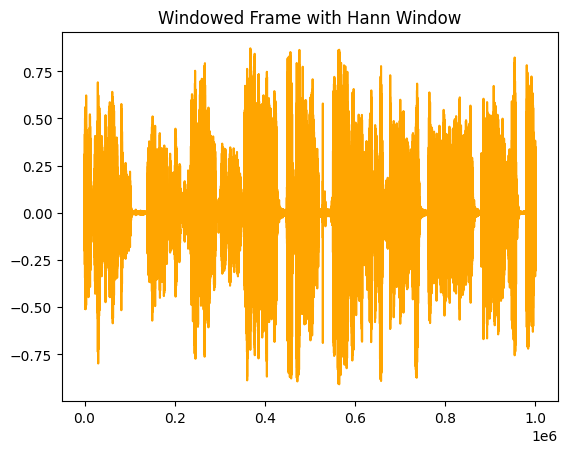

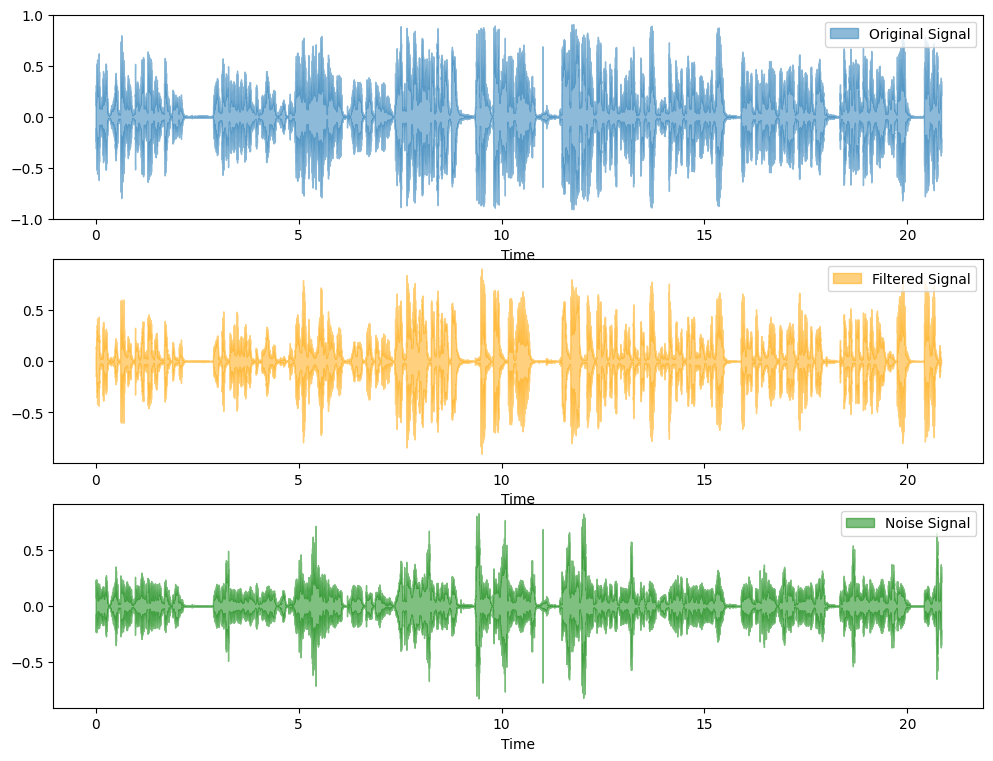

In [14]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Define the bandpass filter
def bandpass_filter(data, sr, lowcut, highcut, order=5):
    nyquist = 0.5 * sr
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y_filtered = filtfilt(b, a, data)
    return y_filtered

# Load the audio
y = y_clean
# Define the bandpass filter parameters
lowcut = 300.0  # Lower bound of the frequency (Hz)
highcut = 3000.0  # Upper bound of the frequency (Hz)

# Apply the bandpass filter
y_filtered = bandpass_filter(y, sr, lowcut, highcut)

# Plot the original, filtered, and noise signals

plt.plot(y, label='Windowed Frame (Hann)', color='orange')
plt.title('Windowed Frame with Hann Window')

plt.figure(figsize=(12, 9))
plt.subplot(3, 1, 1)
librosa.display.waveshow(y, sr=sr, alpha=0.5, label='Original Signal')
plt.legend()

plt.subplot(3, 1, 2)
librosa.display.waveshow(y_filtered, sr=sr, alpha=0.5, label='Filtered Signal', color='orange')
plt.legend()

plt.subplot(3, 1, 3)
noise_signal = y - y_filtered
librosa.display.waveshow(noise_signal, sr=sr, alpha=0.5, label='Noise Signal', color='green')
plt.legend()

plt.show()


In [15]:
print(y_filtered.shape, y.shape)

(999936,) (999936,)


In [16]:
def rms_normalization(audio, target_rms=0.1):
    """
    Perform RMS normalization on an audio signal.

    Parameters:
    - audio: 1D numpy array, the input audio signal
    - target_rms: float, the target RMS level (default 0.1)

    Returns:
    - normalized_audio: 1D numpy array, the normalized audio signal
    """
    # Compute the current RMS value
    rms = np.sqrt(np.mean(audio ** 2))
    
    # Compute the normalization factor
    normalization_factor = target_rms / rms if rms > 0 else 1.0
    
    # Normalize the audio
    normalized_audio = audio * normalization_factor
    
    return normalized_audio

normalized_frames= rms_normalization(windowed_frames,target_rms=0.1)
print(np.max(np.abs(normalized_frames)))

plt.plot(normalized_frames, label='normalized Frame (Hann)', color='orange')
plt.title('Windowed Frame with Hann Window')
plt.show()

NameError: name 'windowed_frames' is not defined

In [ ]:
def pre_processing()

# MFCC

In [ ]:
signal, sample_rate = y_filtered, 48000
print((signal.shape[0]-1024)/512)
# RMS normalization
rms = np.sqrt(np.mean(signal**2))
signal_normalized = signal / (rms + 1e-8)

# Extract MFCCs with Hann windowing
mfccs = librosa.feature.mfcc(
    y=signal_normalized,
    sr=sample_rate,
    n_mfcc=13,
    n_fft=1024,
    hop_length=512,
    window='hann'
)
print(mfccs.shape)

# Mean normalization (optional)
mfccs_mean_normalized = mfccs - np.mean(mfccs)
Features.append(mfccs)

1951.0
(13, 1954)


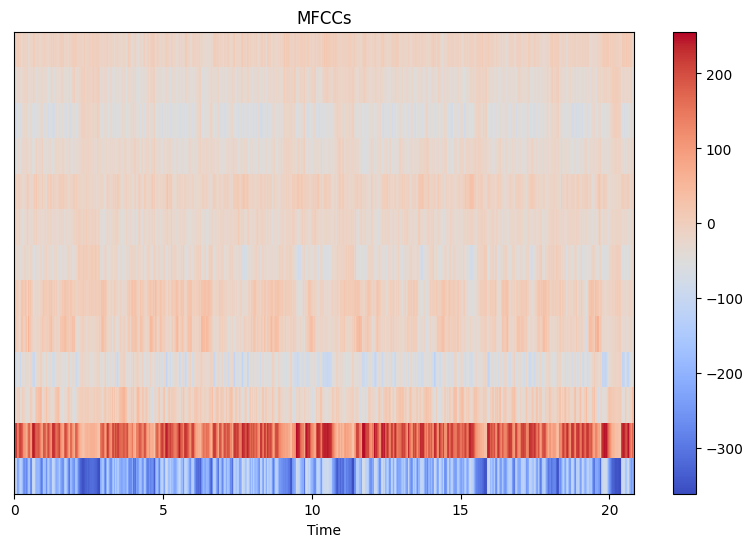

In [143]:
# Plot MFCCs
plt.figure(figsize=(10, 6))
librosa.display.specshow(mfccs, x_axis='time', sr=sr)
plt.title('MFCCs')
plt.colorbar()
plt.show()

#  SC

[[2363.95891365 2272.26103179 2266.86444466 ... 2170.56158961
  2222.37600432 3209.20990924]]


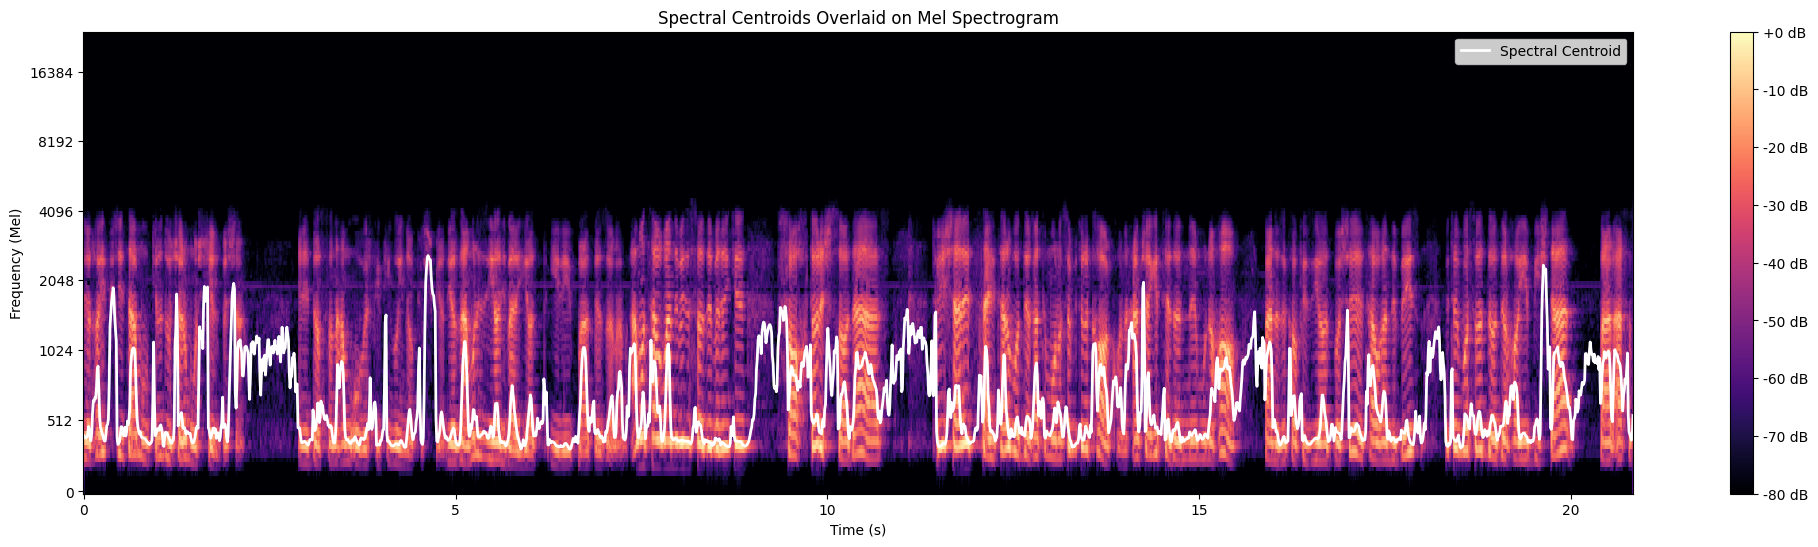

In [141]:
S_mel = librosa.feature.melspectrogram(y=y_filtered, sr=sr, n_mels=128, fmax=sr // 2)

# Step 3: Convert Mel spectrogram to dB for visualization
S_mel_db = librosa.power_to_db(S_mel, ref=np.max)
# Extract MFCCs with Hann windowing
SC = librosa.feature.spectral_centroid(
    S=S_mel,
    sr=sample_rate,
    n_fft=1024,
    hop_length=512,
    window='hann'
)
print(SC.shape)

# Step 5: Time array for the spectral centroids
frames = range(SC.shape[1])
t = librosa.frames_to_time(frames, sr=sr)

# Step 6: Convert spectral centroids to Mel scale for overlay
mel_frequencies = librosa.mel_frequencies(n_mels=128, fmin=0, fmax=sr // 2)
centroid_mel = np.interp(SC[0], np.linspace(0, sr // 2, len(mel_frequencies)), mel_frequencies)

# Step 7: Plot the Mel spectrogram with spectral centroids
plt.figure(figsize=(25, 6))
librosa.display.specshow(S_mel_db, sr=sr, x_axis='time', y_axis='mel', cmap='magma')
plt.plot(t, centroid_mel, color='white', linewidth=2, label='Spectral Centroid')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectral Centroids Overlaid on Mel Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Mel)')
plt.legend(loc='upper right')
plt.show()


# BC

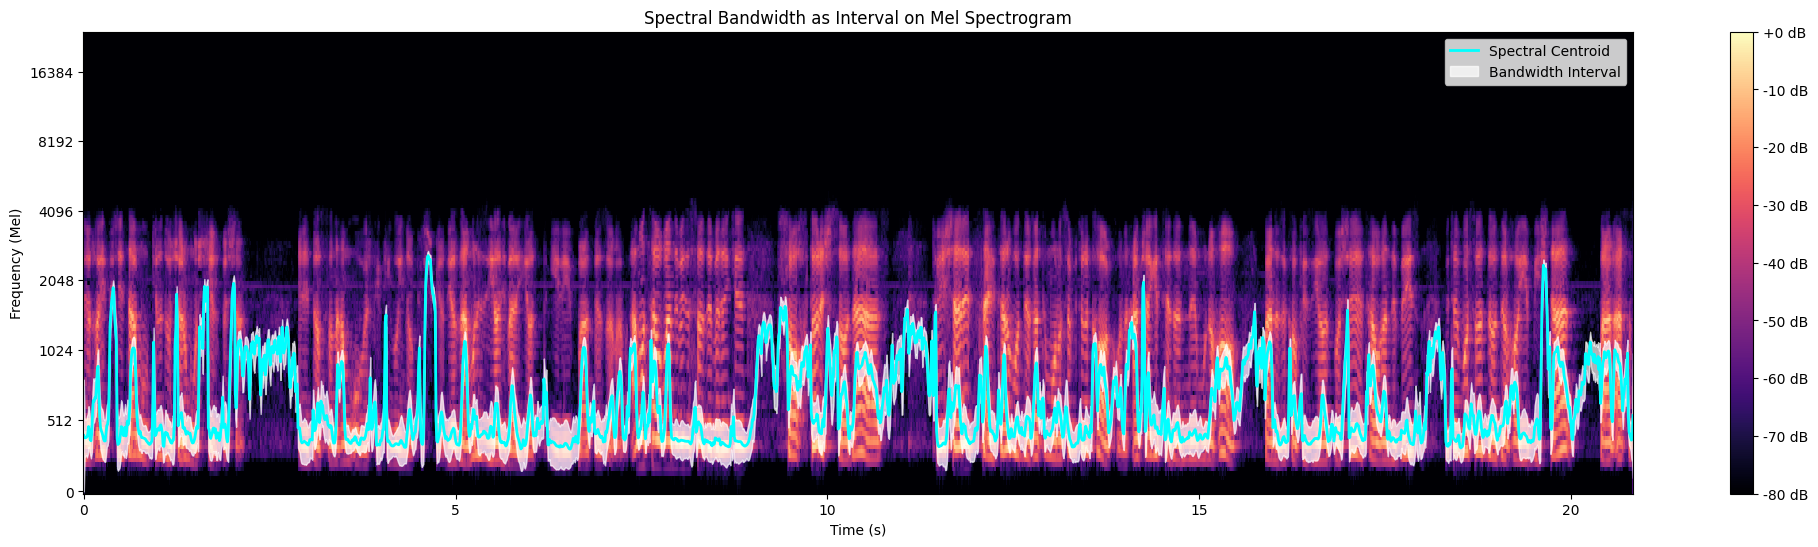

In [142]:
S_mel = librosa.feature.melspectrogram(y=y_filtered, sr=sr, n_mels=128, fmax=sr // 2)

# Step 3: Convert the Mel spectrogram to dB scale for visualization
S_mel_db = librosa.power_to_db(S_mel, ref=np.max)
spectral_centroids = SC
# Step 4: Compute spectral centroid and spectral bandwidth
spectral_bandwidth = librosa.feature.spectral_bandwidth(
    y=y_filtered,
    sr=sample_rate,
    n_fft=1024,
    hop_length=512,
    window='hann'
)
# Step 5: Time array for centroids and bandwidth
frames = range(spectral_centroids.shape[1])
t = librosa.frames_to_time(frames, sr=sr)

# Step 6: Convert centroids and bandwidth to Mel scale
mel_frequencies = librosa.mel_frequencies(n_mels=128, fmin=0, fmax=sr // 2)
centroids_mel = np.interp(spectral_centroids[0], np.linspace(0, sr // 2, len(mel_frequencies)), mel_frequencies)
bandwidth_mel = np.interp(spectral_bandwidth[0], np.linspace(0, sr // 2, len(mel_frequencies)), mel_frequencies)

# Calculate the interval (centroid ± bandwidth)
upper_bound = centroids_mel + bandwidth_mel
lower_bound = centroids_mel - bandwidth_mel

# Step 7: Plot the Mel spectrogram with spectral centroid and bandwidth interval
plt.figure(figsize=(25, 6))
librosa.display.specshow(S_mel_db, sr=sr, x_axis='time', y_axis='mel', cmap='magma')
plt.plot(t, centroids_mel, color='cyan', linewidth=2, label='Spectral Centroid')
plt.fill_between(t, lower_bound, upper_bound, color='white', alpha=0.7, label='Bandwidth Interval')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectral Bandwidth as Interval on Mel Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Mel)')
plt.legend(loc='upper right')
plt.show()

In [ ]:
mel = librosa.feature.melspectrogram(
    y=signal_normalized,
    sr=sample_rate,
    n_fft=1024,
    n_mels=128,
    fmax= sample_rate//2,
    hop_length=512,
    window='hann'
)
print(mel.shape)
log_mel_spectrogram = librosa.power_to_db(mel)  # Convert to decibel scale (log)
print("Log Mel Spectrogram Shape:", log_mel_spectrogram.shape)

(128, 1954)
Log Mel Spectrogram Shape: (128, 1954)


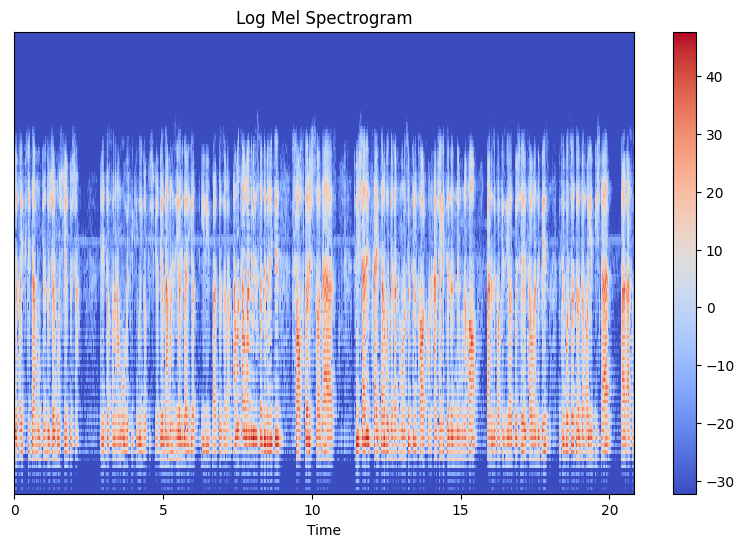

In [144]:
# Plot Log Mel Spectrogram
plt.figure(figsize=(10, 6))
librosa.display.specshow(log_mel_spectrogram, x_axis='time', sr=sr)
plt.title('Log Mel Spectrogram')
plt.colorbar()
plt.show()

In [121]:
# Extract MFCCs with Hann windowing
Scon= librosa.feature.spectral_contrast(
    y=signal_normalized,
    sr=sample_rate,
    n_fft=1024,
    hop_length=512,
    window='hann'
)
print(Scon.shape)

(7, 1954)


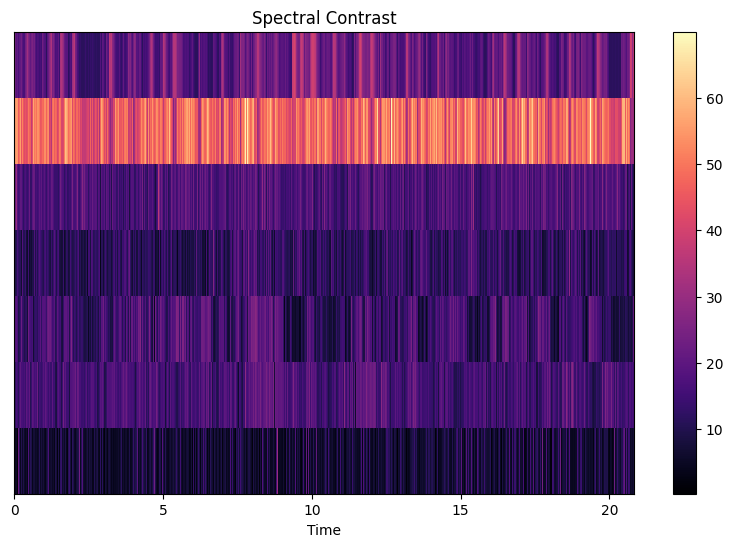

In [145]:
# Plot Spectral Contrast
plt.figure(figsize=(10, 6))
librosa.display.specshow(Scon, x_axis='time', sr=sr)
plt.title('Spectral Contrast')
plt.colorbar()
plt.show()


[[0.00830078 0.01269531 0.01660156 ... 0.01513672 0.01123047 0.00732422]]


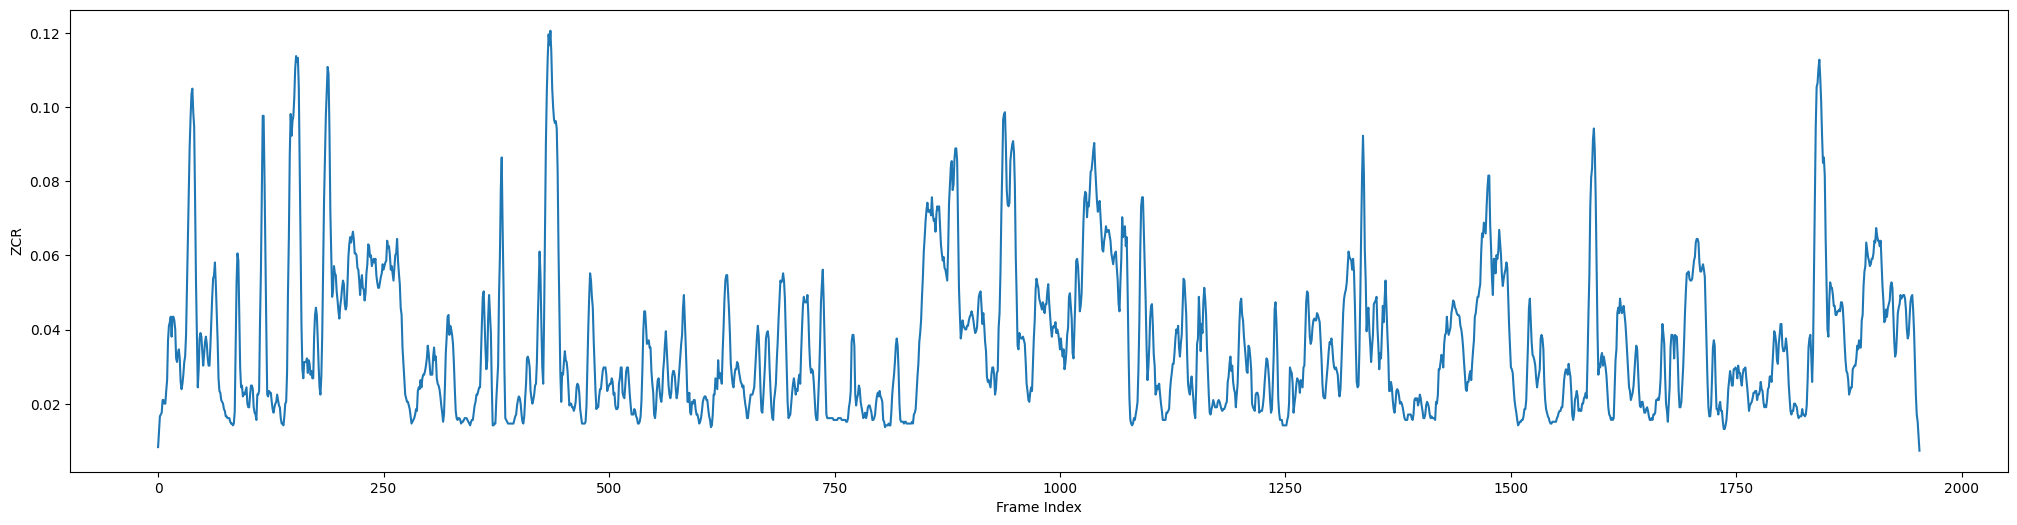

In [152]:
Zcr= librosa.feature.zero_crossing_rate(
    y=signal_normalized,
    frame_length= 2048,
    hop_length=512
)
print(Zcr.shape)

plt.figure(figsize=(25,6))
plt.plot(range(Zcr.shape[1]),Zcr[0,:])
plt.xlabel("Frame Index")
plt.ylabel('ZCR')
plt.show()